Projet sur les systèmes de recommandation avec la librairie LightFM
===============

Il s'agit d'un concours Kaggle dédié aux [recommandations d'article de mode de chez H&M](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/). Les soumissions sont évaluées selon la précision moyenne @12 (MAP@12).

## 1. Packages, configurations et importation des données

La première étape consiste à déclarer les librairies et à les configurer.

In [1]:
# BASE
# ------------------------------------------------------

import gc
import itertools
import pickle
import time
import warnings
from functools import partial
from multiprocessing import Pool

import numpy as np
import pandas as pd

# MODELING
# ------------------------------------------------------
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# DATA VISUALIZATION
# ------------------------------------------------------
import seaborn as sns
from matplotlib import pyplot as plt

# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')
gc.enable()

/Users/edy/miniconda3/envs/data-study/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
article_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv",
                           dtype={'article_id': str})
customer_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv",
                                dtype={'article_id': str}, parse_dates=['t_dat'])

## 2. Analyse exploratoire des données

Nous disposons de différents types de données pour nous aider à obtenir des recommandations :

`images` : images pour chaque article

`articles` : métadonnées détaillées pour chaque article

`customers` : métadonnées détaillées de chaque client

`transactions_train` : achats détaillés

### 2.1. Données sur les articles

Le dataset des articles contient la description de chaque article avec des détails tels qu'un type de produit, une couleur, un groupe de produits et d'autres caractéristiques. Les variables décrivant les articles sont de type catégoriel. 

In [3]:
print(article_data.shape)
article_data.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


Il n'y a pas de doublons d'identifiant. Chaque ligne décrit ainsi chaque article de façon unique.

In [4]:
article_data.shape[0] - article_data['article_id'].nunique()

0

Nous pouvons observer les catégories présentant le plus grand nombre d'articles. On constate que les articles pour femmes représentent la part la plus importante des articles contrairement aux articles de sport. De plus le Jersey Fancy est le vêtement le plus frequent dans chaque catégorie.

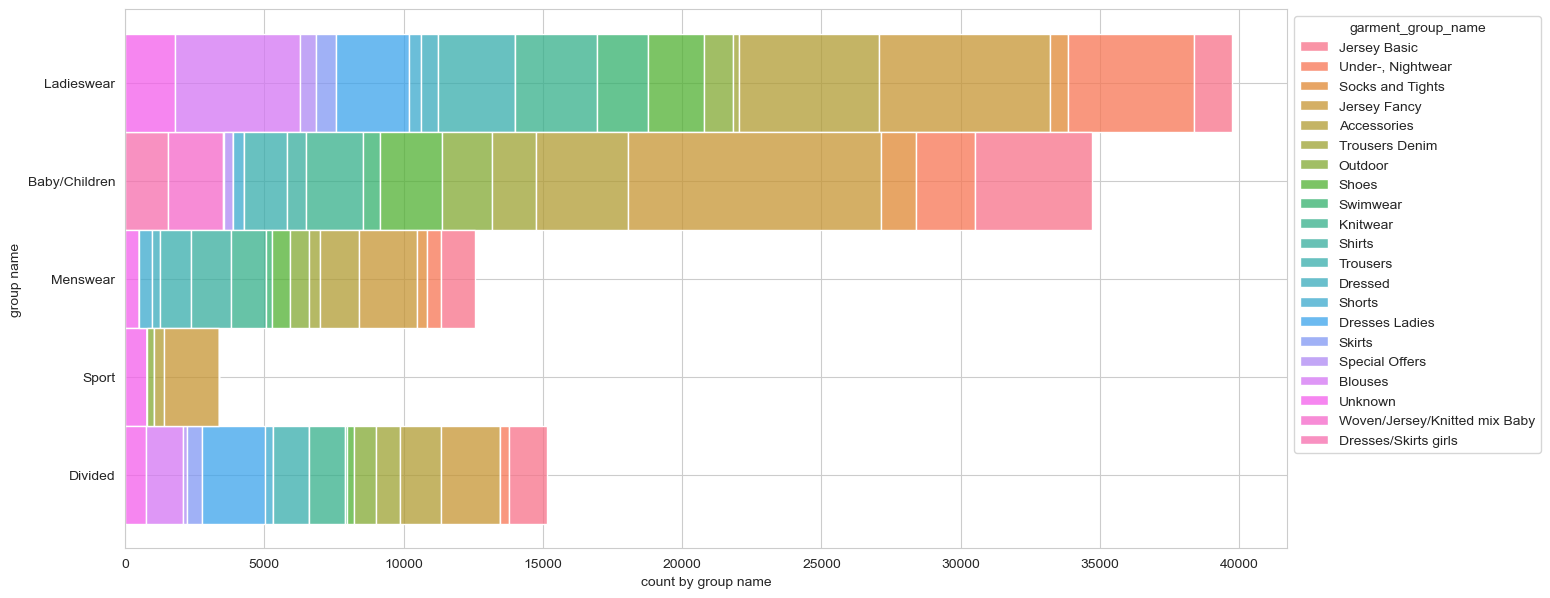

In [5]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=article_data, y='index_group_name', color='pink', hue='garment_group_name', multiple="stack")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel('count by group name')
ax.set_ylabel('group name')
plt.show()

### 2.2. Données sur les clients

Le dataset des clients contient la description de chaque client avec des détails tel que l'age et le code postal.

In [6]:
print(customer_data.shape)
customer_data.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.00,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.00,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.00,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.00,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.00,1.00,ACTIVE,Regularly,52.00,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


Il n'y a pas de doublons d'identifiant. Chaque ligne décrit ainsi chaque client de façon unique.

In [7]:
customer_data.shape[0] - customer_data['customer_id'].nunique()

0

On peut constater que la majorité des clients ont entre 21 et 25 ans.

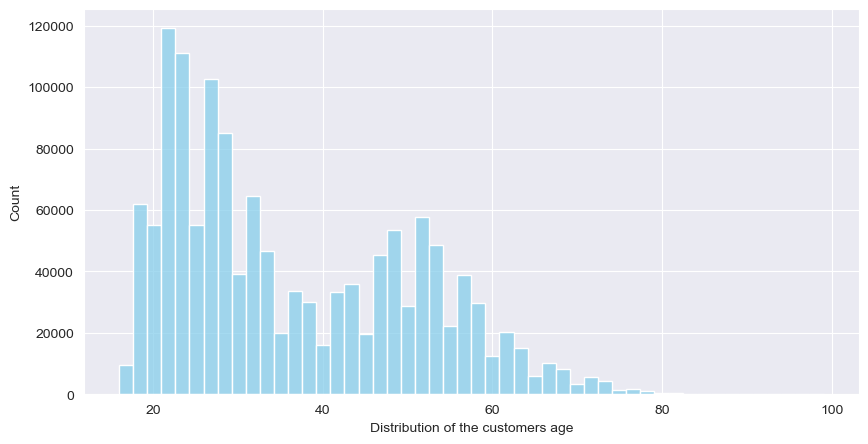

In [8]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10, 5))
ax = sns.histplot(data=customer_data, x='age', bins=50, color='skyblue')
ax.set_xlabel('Distribution of the customers age')
plt.show()

### 2.3. Données sur les transactions

Le dataset des transactions contient la description de chaque achat avec des détails tels que le montant de l'achat et les identifiants du client et de l'article.

In [9]:
print(transactions_data.shape)
transactions_data.head()

(31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.05,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.03,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.02,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.02,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.02,2


Nous pouvons observer le minimum, la médiane, le maximum et les valeurs abérrantes des montants de toutes les transactions.

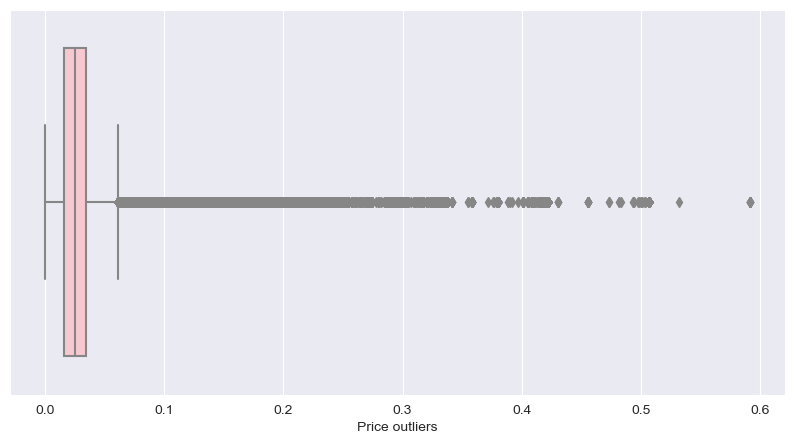

In [10]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(data=transactions_data, x='price', color='pink')
ax.set_xlabel('Price outliers')
plt.show()

## 3. Recommandations basées sur un filtrage collaboratif sans les caractéristiques d'articles et d'utilisateurs

### 3.1. Matrice d'interaction utilisateur-élément

Étant donné qu'un système de recommandation sur des données volumineux est très coûteux en termes de calcul, nous ne l'appliquerons qu'à un petit sous-ensemble d'utilisateurs. 

Nous ne conservons que l’historique le plus récent, soit à partir de `'2020-08-21'`.

In [11]:
customer_to_article = transactions_data[transactions_data['t_dat'] > '2020-08-21']

customer_to_article = customer_to_article.groupby(['customer_id', 'article_id']).agg(
    {'price': 'sum', 't_dat': 'count'}).reset_index()

customer_to_article = customer_to_article.rename(columns={"t_dat": "product_count"})
customer_to_article = customer_to_article.rename(columns={"price": "total_amount_spent"})

print(customer_to_article.shape)
customer_to_article.head()

(1051730, 4)


,customer_id,article_id,total_amount_spent,product_count
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043,0.05,1
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,0.06,1
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0448509014,0.04,1
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0719530003,0.03,1
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0516859008,0.01,1


Nous devons créer un mappage entre les identifiants d'utilisateur et d'élément de nos données d'entrée vers les indices qui seront utilisés en interne par notre modèle.

Nous faisons cela parce que LightFM fonctionne avec des identifiants d'utilisateur et d'élément qui sont des entiers consécutifs non négatifs. La classe `Dataset` nous permet de créer un mappage entre les identifiants que nous utilisons dans nos systèmes et les indices consécutifs préférés par le modèle.

In [12]:
print('Num users: {}, num_items {}.'.format(len(customer_data['customer_id'].unique()),
                                            len(article_data['article_id'].unique())))

Num users: 1371980, num_items 105542.


In [13]:
dataset = Dataset()
dataset.fit(customer_data['customer_id'].unique(),
            article_data['article_id'].unique())

Nous pouvons vérifier que les mappages ont été créés en interrogeant l'ensemble de données sur le nombre d'utilisateurs et d'articles dont il connaît.

In [14]:
print('Num users: {}, num_items {}.'.format(dataset.interactions_shape()[0], dataset.interactions_shape()[1]))

Num users: 1371980, num_items 105542.


Après avoir créé la cartographie, nous construisons la matrice d'interaction en considérant le nombre total d'un même article acheté par un utilisateur sur une transaction comme poids de l'interaction.

In [15]:
(interactions, interactions_weights) = dataset.build_interactions(
    customer_to_article[["customer_id", "article_id", "product_count"]].itertuples(index=False, name=None))

print(repr(interactions_weights))

<1371980x105542 sparse matrix of type '<class 'numpy.float32'>'
	with 1051730 stored elements in COOrdinate format>


### 3.2. Tuning des hyper-paramètres par recherche aléatoire

In [16]:
def sample_hyperparameters():
    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(train_interactions_weights, test_interactions_weights, num_samples=50, num_threads=8):
    for hyperparams in tqdm(itertools.islice(sample_hyperparameters(), num_samples), total=num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train_interactions_weights, sample_weight=None, epochs=num_epochs,
                  num_threads=num_threads)

        score = precision_at_k(model, test_interactions_weights, train_interactions=train_interactions_weights, k=12,
                               num_threads=num_threads).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

In [17]:
interactions_weights_train, interactions_weights_test = random_train_test_split(interactions_weights,
                                                                                test_percentage=0.2,
                                                                                random_state=np.random.RandomState(42))

In [13]:
gc.collect()

(score, hyperparams, model) = max(random_search(train_interactions_weights=interactions_weights_train,
                                                test_interactions_weights=interactions_weights_test,
                                                num_threads=8), key=lambda x: x[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [3:54:50<00:00, 279.14s/it]


In [18]:
optimized_dict = {'score': score,
                  'params': hyperparams}

# with open('optimized_dict_1.pkl', 'wb') as f:
#    pickle.dump(optimized_dict, f)

optimized_dict

{'score': 0.012020846,
 'params': {'no_components': 61,
  'learning_schedule': 'adagrad',
  'loss': 'bpr',
  'learning_rate': 0.04588163187556629,
  'item_alpha': 3.582920782164289e-10,
  'user_alpha': 1.6679723411950124e-09,
  'max_sampled': 12,
  'num_epochs': 39}}

Le modèle le plus optimale trouvé par recherche aléatoire a une précision de `0.012020846` sur les données de test.

### 3.3. Entrainement du modèle à soumettre

In [19]:
best_hyperparams = optimized_dict['params']
num_epochs = best_hyperparams.pop("num_epochs")

In [20]:
model_1 = LightFM(**best_hyperparams)

start = time.time()
model_1.fit(interactions_weights,
            user_features=None,
            item_features=None,
            sample_weight=None,
            epochs=num_epochs,
            num_threads=8,
            verbose=False)
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 146.51 seconds


In [ ]:
class PreprocessorWithoutFeatures():
    def __init__(self, model, dataset):
        self.model = model
        self.item_ids = list(dataset.mapping()[2].values())

    def get_scores(self, user_ids):
        return self.model.predict(user_ids=user_ids, item_ids=self.item_ids)


class RecommendationSystem():
    def __init__(self, preprocessor, dataset, interaction_matrix):
        self.preprocessor = preprocessor
        self.interaction_matrix = interaction_matrix
        self.items = np.asarray(list(dataset.mapping()[2].keys()))
        self.user_to_index_mapping = dataset.mapping()[0]

    def get_batched_recommendation(self, user, k=12):
        user_ids = self.user_to_index_mapping.get(user, None)
        if user_ids is None:
            return None

        # Scores from model
        scores = self.preprocessor.get_scores(user_ids)

        # Top items
        top_items = self.items[np.argsort(-scores)]

        return top_items[:k]

    def recommendation_for_user(self, user, k=12):
        user_ids = self.user_to_index_mapping.get(user, None)
        if user_ids == None:
            print("User %s not provided during Training the model" % (user))
            return None

        # Products already bought
        known_positives = self.items[self.interaction_matrix.tocsr()[user_ids].indices]

        # Scores from model prediction
        scores = self.preprocessor.get_scores(user_ids)

        # Top items
        top_items = self.items[np.argsort(-scores)]

        # Printing out the result
        print("User %s" % user)
        print("     Known positives:")
        for x in known_positives[:k]:
            print("                  %s" % x)

        print("     Recommended:")
        for x in top_items[:k]:
            print("                  %s" % x)

In [21]:
preprocessor_without_features = PreprocessorWithoutFeatures(model=model_1, dataset=dataset)
model_without_features = RecommendationSystem(preprocessor=preprocessor_without_features,
                                              dataset=dataset,
                                              interaction_matrix=interactions_weights)

In [22]:
model_without_features.recommendation_for_user('00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657', 12)

User 00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657
     Known positives:
                  0568601043
     Recommended:
                  0568601043
                  0568597007
                  0568601007
                  0779781006
                  0568601030
                  0568597006
                  0779781015
                  0779781013
                  0858856005
                  0889456002
                  0568601044
                  0716670009


### 3.4. Prédictions à soumettre

In [15]:
top_selling_article_list = list((transactions_data['article_id'].value_counts(sort=True, ascending=False)).index)[:12]
top_selling_article_str = ' '.join(top_selling_article_list)
top_selling_article_str

'0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001'

In [16]:
num_cores = 8
customer_ids = customer_data['customer_id'].unique()
customer_id_chunks = np.array_split(customer_ids, num_cores)

In [17]:
gc.collect()

0

In [ ]:
def predict_sub_chunks(chunk, model: RecommendationSystem, top_selling_article_str):
    final_submission = []
    for row in tqdm(chunk):
        try:
            preds = model.get_batched_recommendation(row, 12)
            if preds is not None:
                final_submission.append(' '.join(map(str, preds)))
            else:
                final_submission.append(top_selling_article_str)
        except Exception as ex:
            print(ex)
    return final_submission

In [21]:
predict = partial(predict_sub_chunks, model=model_without_features,
                  top_selling_article_str=top_selling_article_str)

with Pool(num_cores) as pool:
    result = pool.map(predict, customer_id_chunks)

 87%|████████▋ | 148657/171498 [9:27:04<1:28:51,  4.28it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 86%|████████▌ | 147505/171497 [9:32:52<1:32:46,  4.31it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 88%|████████▊ | 150745/171498 [9:39:00<1:15:12,  4.60it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerAp

In [22]:
result_combined = list(itertools.chain(result[0], result[1], result[2], result[3],
                                       result[4], result[5], result[6], result[7]))
print(len(customer_ids))
print(len(result_combined))

1371980
1371980


In [24]:
submission_data_1 = pd.DataFrame({'customer_id': customer_ids, 'prediction': result_combined})
submission_data_1.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0858856005 0779781015 0695632002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0552716012 0942069001 0799365013 0633152012 06...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0805000007 0805000008 0730683062 08...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0799365013 0633152012 0552716012 0942069001 08...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0552716012 0799365013 0633152012 0942069001 08...


## 4. Recommandations basées sur un filtrage hybride avec les caractéristiques d'articles et d'utilisateurs

### 4.1. Prétraitement des données

Étant donné que chaque article présente de nombreuses caractéristiques, nous devons rechercher, les caractéristiques les plus pertinentes pour nos recommandations. Nous choisissons ainsi l'age et le code postal pour les utilisateurs et toutes les caractéristiques non redondantes pour les articles. 

- Prétraitement des utilisateurs

In [27]:
print(customer_data.shape)
customer_data.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.00,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.00,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.00,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.00,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.00,1.00,ACTIVE,Regularly,52.00,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [18]:
user_features_list = ["age", "postal_code"]

customer_data_min = customer_data[["customer_id"] + user_features_list]
print(customer_data_min.shape)
customer_data_min.head()

(1371980, 3)


,customer_id,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.00,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.00,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.00,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.00,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.00,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


Nous encodons les caractéristiques des utilisateurs qui sont catégorielles en labels plus légers pour optimiser les performances des traitements. 

In [19]:
le_customer_data = LabelEncoder()

customer_data_min["postal_code"] = customer_data_min[["postal_code"]].apply(
    lambda x: le_customer_data.fit_transform(x))
customer_data_min[user_features_list] = customer_data_min[user_features_list].astype(str)
print(customer_data_min.shape)
customer_data_min.head()

(1371980, 3)


,customer_id,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,112978
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,57312
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,139156
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,128529
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0,52371


In [20]:
customer_data_min.dtypes

customer_id    object
age            object
postal_code    object
dtype: object

- Prétraitement des articles

In [21]:
print(article_data.shape)
article_data.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [22]:
item_features_list = ["product_code", "product_type_no", "product_group_name", "graphical_appearance_no",
                      "colour_group_code", "perceived_colour_value_id", "perceived_colour_master_id", "department_no",
                      "index_code", "index_group_no", "section_no", "garment_group_no"]
article_data_min = article_data[["article_id"] + item_features_list]
print(article_data_min.shape)
article_data_min.head()

(105542, 13)


,article_id,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,0108775015,108775,253,Garment Upper body,1010016,9,4,5,1676,A,1,16,1002
1,0108775044,108775,253,Garment Upper body,1010016,10,3,9,1676,A,1,16,1002
2,0108775051,108775,253,Garment Upper body,1010017,11,1,9,1676,A,1,16,1002
3,0110065001,110065,306,Underwear,1010016,9,4,5,1339,B,1,61,1017
4,0110065002,110065,306,Underwear,1010016,10,3,9,1339,B,1,61,1017


In [23]:
article_data_min.dtypes

article_id                    object
product_code                   int64
product_type_no                int64
product_group_name            object
graphical_appearance_no        int64
colour_group_code              int64
perceived_colour_value_id      int64
perceived_colour_master_id     int64
department_no                  int64
index_code                    object
index_group_no                 int64
section_no                     int64
garment_group_no               int64
dtype: object

Nous encodons les caractéristiques des articles qui sont catégorielles en labels plus légers pour optimiser les performances des traitements. 

In [24]:
le_article_data = LabelEncoder()

article_data_min[item_features_list] = article_data_min[item_features_list].apply(
    lambda x: le_article_data.fit_transform(x))
article_data_min[item_features_list] = article_data_min[item_features_list].astype(str)
print(article_data_min.shape)
article_data_min.head()

(105542, 13)


,article_id,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,0108775015,0,48,7,16,9,4,5,47,0,0,8,1
1,0108775044,0,48,7,16,10,3,9,47,0,0,8,1
2,0108775051,0,48,7,17,11,1,9,47,0,0,8,1
3,0110065001,1,90,16,16,9,4,5,12,1,0,43,14
4,0110065002,1,90,16,16,10,3,9,12,1,0,43,14


In [25]:
article_data_min.dtypes

article_id                    object
product_code                  object
product_type_no               object
product_group_name            object
graphical_appearance_no       object
colour_group_code             object
perceived_colour_value_id     object
perceived_colour_master_id    object
department_no                 object
index_code                    object
index_group_no                object
section_no                    object
garment_group_no              object
dtype: object

### 4.2. Matrices d'interaction élément-caractéristiques et utilisateur-caractéristiques

In [26]:
article_data_min.head()

,article_id,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,0108775015,0,48,7,16,9,4,5,47,0,0,8,1
1,0108775044,0,48,7,16,10,3,9,47,0,0,8,1
2,0108775051,0,48,7,17,11,1,9,47,0,0,8,1
3,0110065001,1,90,16,16,9,4,5,12,1,0,43,14
4,0110065002,1,90,16,16,10,3,9,12,1,0,43,14


In [27]:
customer_data_min.head()

,customer_id,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,112978
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,57312
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,139156
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,128529
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0,52371


Les caractéristiques des utilisateurs et des articles étant des variables catégorielles, nous considérons chaque modalité de ces variables comme caractéristique unique dans les matrices d'articles et d'utilisateurs.

In [28]:
def get_uniques_by_columns(dataframe, columns):
    dataframe = dataframe.applymap(str)
    uniques = list()
    for col in columns:
        uniques.extend(dataframe[col].unique())
    return uniques

In [29]:
dataset.fit_partial(
    item_features=get_uniques_by_columns(article_data_min, item_features_list),
    user_features=get_uniques_by_columns(customer_data_min, user_features_list),
)

In [30]:
print('Num_item_ids: {}, Num_item_features {}.'.format(dataset.item_features_shape()[0],
                                                       dataset.item_features_shape()[1]))

Num_item_ids: 105542, Num_item_features 152766.


In [31]:
print('Num_user_ids: {}, Num_user_features {}.'.format(dataset.user_features_shape()[0],
                                                       dataset.user_features_shape()[1]))

Num_user_ids: 1371980, Num_user_features 1724964.


Regroupons les données sur les transactions avec les métadonnées d'articles et d'utilisateur afin de construire leur matrices.

In [32]:
transactions_full_min = transactions_data[transactions_data['t_dat'] > '2020-08-21']
transactions_full_min = transactions_full_min[['article_id', 'customer_id']].merge(
    customer_data_min, on='customer_id', how='left').merge(
    article_data_min, on='article_id', how='left')

print(transactions_full_min.shape)
transactions_full_min.head()

(1190911, 16)


,article_id,customer_id,age,postal_code,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,0913688003,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,44.0,202732,45882,53,7,1,13,2,11,23,0,0,7,8
1,0913688003,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,44.0,202732,45882,53,7,1,13,2,11,23,0,0,7,8
2,0923460001,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,44.0,202732,46442,68,6,1,25,2,13,18,0,0,7,10
3,0934380001,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,44.0,202732,46969,92,7,14,33,4,4,33,3,1,37,3
4,0913688001,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,44.0,202732,45882,53,7,16,10,3,9,23,0,0,7,8


In [33]:
def prepare_features_format(data, id, feature_columns):
    for row in data.iterrows():
        yield (row[1][id], [str(row[1][feature]) for feature in feature_columns])


In [34]:
item_features = dataset.build_item_features(
    prepare_features_format(transactions_full_min, "article_id", item_features_list)
)
print(repr(item_features))

<105542x152766 sparse matrix of type '<class 'numpy.float32'>'
	with 412513 stored elements in Compressed Sparse Row format>


In [35]:
user_features = dataset.build_user_features(
    prepare_features_format(transactions_full_min, "customer_id", user_features_list)
)
print(repr(user_features))

<1371980x1724964 sparse matrix of type '<class 'numpy.float32'>'
	with 1884690 stored elements in Compressed Sparse Row format>


### 4.3. Tuning des hyper-paramètres par recherche aléatoire

In [50]:
def random_search_opt(train_interactions_weights, test_interactions_weights,
                      user_features=user_features,
                      item_features=item_features,
                      num_samples=50, num_threads=8):
    for hyperparams in tqdm(itertools.islice(sample_hyperparameters(), num_samples), total=num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train_interactions_weights, sample_weight=None, epochs=num_epochs,
                  num_threads=num_threads,
                  item_features=item_features,
                  user_features=user_features)

        score = precision_at_k(model, test_interactions_weights, train_interactions=train_interactions_weights,
                               item_features=item_features,
                               user_features=user_features,
                               k=12,
                               num_threads=num_threads).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

In [48]:
gc.collect()

230

In [51]:
(score, hyperparams, model) = max(random_search_opt(train_interactions_weights=interactions_weights_train,
                                                    test_interactions_weights=interactions_weights_test,
                                                    user_features=user_features,
                                                    item_features=item_features,
                                                    num_threads=8), key=lambda x: x[0])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [8:14:26<00:00, 394.21s/it]


In [36]:
optimized_dict_opt = {'score': score,
                      'params': hyperparams}

# with open('optimized_dict_2.pkl', 'wb') as f:
#     pickle.dump(optimized_dict_opt, f)

optimized_dict_opt

{'score': 0.005051397,
 'params': {'no_components': 58,
  'learning_schedule': 'adadelta',
  'loss': 'warp-kos',
  'learning_rate': 0.02831799038773959,
  'item_alpha': 7.146026267310411e-09,
  'user_alpha': 5.344231738525779e-10,
  'max_sampled': 14,
  'num_epochs': 42}}

Le modèle le plus optimale trouvé par recherche aléatoire a une précision de `0.005051397` sur les données de test.

### 4.4. Entrainement du modèle à soumettre

In [37]:
best_hyperparams_opt = optimized_dict_opt['params']
num_epochs_opt = best_hyperparams_opt.pop("num_epochs")

In [38]:
model_2 = LightFM(**best_hyperparams_opt)

start = time.time()
model_2.fit(interactions_weights,
            user_features=user_features,
            item_features=item_features,
            sample_weight=None,
            epochs=num_epochs_opt,
            num_threads=8,
            verbose=False)
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 200.03 seconds


In [ ]:
class PreprocessorWithFeatures():
    def __init__(self, model, dataset, item_features, user_features):
        self.model = model
        self.item_features = item_features if item_features is not None else None
        self.user_features = user_features if user_features is not None else None
        self.item_ids = list(dataset.mapping()[2].values())

    def get_scores(self, user_ids):
        return self.model.predict(user_ids=user_ids,
                                  item_ids=self.item_ids,
                                  item_features=self.item_features,
                                  user_features=self.user_features)

In [39]:
preprocessor_with_features = PreprocessorWithFeatures(model=model_2, dataset=dataset, item_features=item_features,
                                                      user_features=user_features)
model_with_features = RecommendationSystem(preprocessor=preprocessor_with_features,
                                           dataset=dataset,
                                           interaction_matrix=interactions_weights)

In [40]:
model_with_features.recommendation_for_user('00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657', 12)

User 00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657
     Known positives:
                  0568601043
     Recommended:
                  0869473003
                  0839496004
                  0865929014
                  0865929007
                  0865929003
                  0892455003
                  0884319007
                  0832359003
                  0873678007
                  0884319003
                  0819520008
                  0930380001


### 4.5. Prédictions à soumettre

In [41]:
gc.collect()

predict_opt = partial(predict_sub_chunks, model=model_with_features, top_selling_article_str=top_selling_article_str)

with Pool(num_cores) as pool:
    result_opt = pool.map(predict_opt, customer_id_chunks)

100%|██████████| 171497/171497 [16:10:56<00:00,  2.94it/s]


In [42]:
result_combined_opt = list(itertools.chain(result_opt[0], result_opt[1], result_opt[2], result_opt[3],
                                           result_opt[4], result_opt[5], result_opt[6], result_opt[7]))
print(len(customer_ids))
print(len(result_combined_opt))

1371980
1371980


In [43]:
submission_data_2 = pd.DataFrame({'customer_id': customer_ids, 'prediction': result_combined_opt})
submission_data_2.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0869473003 0839496004 0865929014 0865929007 08...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0866482003 0866528001 0738713026 0866503007 08...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0918292004 0905957007 0809961001 0680391023 08...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0866482003 0866528001 0896522005 0738713026 08...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0866482003 0866482004 0866528001 0896522005 08...


## 5. Choix du modèle finale

Le modèle de filtrage collaboratif sans les caractéristiques d’articles et d’utilisateurs avec une précision de `0.012020846` a obtenu de meilleures performances que le modèle de filtrage hybride avec les caractéristiques d'articles et d'utilisateurs avec une précision de `0.005051397`.

In [ ]:
submission_data_1.to_csv('submission.csv', index=False)